<a href="https://colab.research.google.com/github/PrinceSJ/Markov_GameTheory/blob/master/Markov_games_as_a_framework_for_multi_agent_reinforcement_learning_(V2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Minimax-Q Algorithm

For Each Agent $i\in\mathcal{I}$, given the states set $\underline{\textbf{S}}$, the own action set  $\underline{\textbf{A}}$, and the action set of the opponent $\underline{\textbf{O}}$:

### 1. Initialization

```
For all s in states set S, a in own-action set A, o in opponent-action set O:
    Let Q[s,a,o] := 1
    
For all s in S:
    Let V[s] := 1
    
For all s in S, a in A:
    Let pi[s, a] = 1 / |A|
    
Let alpha := 1.0

And other parameters: 
1. the discount factor - gamma; 
2. the exploration factor - explor; 
3. the learning rate decay factor - decay;
```

### 2. Choose An Action

```
With probability explor, return an action uniformly at random.
Otherwise, if current state is s, return action a with probability pi[s, a]
```

### 3. Learning
```
After receiving reward rew for moving from state s to s' via own action a and opponent's action o
    Let Q[s, a, o] := ( 1 - alpha ) * Q[s, a, o] + alpha * ( rew + gamma * V[s'] )
    
    Using linear programming to find the optimal pi[s, .] such that:
        pi[s, .] := argmax{pi'[s, .], min{o', sum{a', pi[s, a'] * Q[s, a', o']}}}
        
    Let V[s] := min{o', sum{a', pi[s, a'] * Q[s, a', o']}}
    
    Let alpha := alpha * decay
```

### Linear Programming to find the optimal $PD(\underline{\textbf{A}}|s)$

According to the notion of optimality, the agent's minimum expected reward should be as large as possible.

Assumed that our unknown is $\underline{\textbf{X}} = {V, pi[s, a_0],...,p[s, a_n]}$, our optimization problem could be defined as the following:

\begin{equation}
  \max_{\pi_a} V\ \longrightarrow\ \min_{\pi_a} -V(its\ dual\ form)\ \ s.t. 
  \begin{cases}
     V - pi[s, a_0] * Q[s, a_0, o_0] - ... - pi[s, a_n] * Q[s, a_n, o_0] \leq 0\\
     .\\
     .\\
     V - pi[s, a_0] * Q[s, a_0, o_n] - ... - pi[s, a_n] * Q[s, a_n, o_n] \leq 0\\
     pi[s, a_0] + ... + pi[s, a_n] = 1
  \end{cases}
\end{equation}




In [0]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import abc

In [0]:
class Agent(object):
  __metaclass__ = abc.ABCMeta
  
  '''
  Default attributes for each agent:
  1. _IsLearning controls whether agent is learning
  2. The size of state set, |S|
  3. The number of actions, |A|
  4. The number of opponent's actions, |O|(only for minimax-Q)
  5. The discount factor, gamma
  6. The learning rate factor, alpha
  7. The rate at which the learning rate decays, decay
  8. The probability to exploration, explor
  '''
  _IsLearning = True
  _Num_of_S = 0
  _Num_of_A = 0
  _Num_of_O = 0
  _Gamma = 0
  _Alpha = 0
  _Decay = 0
  _Explor = 0
  
  def __init__(self):
    super(Agent, self).__init__()
    
  '''
  Protected attributes' setters and getters
  '''
  @property
  def IsLearning(self):
    return self._IsLearning
  
  @IsLearning.setter
  def IsLearning(self, IsLearn):
    self._IsLearning = IsLearn
    
  @property
  def Num_of_S(self):
    return self._Num_of_S
  
  @Num_of_S.setter
  def Num_of_S(self, _val):
    self._Num_of_S = _val
    
  @property
  def Num_of_A(self):
    return self._Num_of_A
  
  @Num_of_A.setter
  def Num_of_A(self, _val):
    self._Num_of_A = _val
    
  @property
  def Num_of_O(self):
    return self._Num_of_O
  
  @Num_of_O.setter
  def Num_of_O(self, _val):
    self._Num_of_O = _val
    
  @property
  def gamma(self):
    return self._Gamma
  
  @gamma.setter
  def gamma(self, _val):
    self._Gamma = _val
    
  @property
  def alpha(self):
    return self._Alpha
  
  @alpha.setter
  def alpha(self, _val):
    self._Alpha = _val
    
  @property
  def decay(self):
    return self._Decay
  
  @decay.setter
  def decay(self, _val):
    self._Decay = _val
    
  @property
  def explor(self):
    return self._Explor
  
  @explor.setter
  def explor(self, _val):
    self._Explor = _val
 
  '''
  Initialize Q, V and Pi matrices
  '''
  @abc.abstractmethod
  def Init_Params(self):
    raise NotImplementedError
  
  '''
  Choose an action from the action set A/O.
  '''
  @abc.abstractmethod
  def Action(self, s):
    raise NotImplementedError
  
  '''
  Update: 
  1. Q(s,a,..): The quality of a state-action pair (s,a) or (s,a,o);
  2. V(s): The value of state s;
  3. Pi(s,...): The agent’s current policy for state s;
  4. Alpha: The learning rate
  '''
  @abc.abstractmethod
  def Update(self, reward, old_s, new_s, a, o):
    raise NotImplementedError
  
  '''
  Using Linear programming solver to calculate:
  1. The maximum of V(s), 
  2. The corresponding optimal policy Pi(s,...)
  '''
  @abc.abstractmethod
  def Optimization(self, old_s, stop=False):
    raise NotImplementedError

In [0]:
class Minimax_Q(Agent):
  
  def __init__(self, *args):
    '''
      Parameters:
      0. The size of state set |S|
      1. The number of the agent's actions |A|
      2. The number of the opponent's actions |O|
      3. The discount factor, gamma
      4. The probability for the agent to explore the entire state space, explor
      5. The rate at which the learning rate decays, decay
    '''
    super(Minimax_Q, self).__init__()
    self.Num_of_S = args[0]
    self.Num_of_A = args[1]
    self.Num_of_O = args[2]
    self.gamma = args[3]
    self.explor = args[4]
    self.decay = args[5]
    self.Init_Params()
  
  def Init_Params(self):
    self.Q = np.ones((self.Num_of_S, self.Num_of_A, self.Num_of_O))
    self.V = np.ones(self.Num_of_S)
    self.Pi = np.ones((self.Num_of_S, self.Num_of_A)) / self.Num_of_A
    self.alpha = 1.0
    
  def Action(self, s):
    if self.IsLearning and np.random.rand() < self.explor:
      return np.random.randint(self.Num_of_A)
    else:
      prob = np.random.rand()
      a = 0
      a += np.sum(prob > np.cumsum(self.Pi[s]))
      return a
    
  def Update(self, reward, old_s, new_s, a, o):
    if not self.IsLearning:
      return
    
    self.Q[old_s, a, o] = (1 - self.alpha) * self.Q[old_s, a, o]\
                            + self.alpha * (reward + self.gamma * self.V[new_s])
    self.V[old_s] = self.Optimization(s)
    self.alpha *= self.decay
    
  def Optimization(self, old_s, stop=False):
    # Coefficients of the objectvie function: -V
    Coeffs_Obj = np.zeros(self.Num_of_A + 1)
    Coeffs_Obj[0] = -1
    
    # Coefficients of the inequality constrains
    Coeffs_Inq = np.ones((self.Num_of_O, self.Num_of_A + 1))
    Coeffs_Inq[:,1:] = -self.Q[old_s,:,:].T
    UB_Inq = np.zeros(self.Num_of_O)
    
    # Coefficients of the equality constrains
    Coeffs_Eq = np.ones((1, self.Num_of_A + 1))
    Coeffs_Eq[0,0] = 0
    UB_Eq = [1]
    
    # Value range of each variable
    Bounds = ((None, None),)
    for i in np.arange(self.Num_of_A):
      Bounds += ((0, 1),)
      
    # Linear programming solver
    res = linprog(Coeffs_Obj, A_ub=Coeffs_Inq, b_ub=UB_Inq\
                 , A_eq=Coeffs_Eq, b_eq=UB_Eq, bounds=Bounds)
    
    # Check Solution
    if res.success:
      self.Pi[old_s] = res.x[1:]
    elif not stop:
      return Optimization(old_s, stop=True)
    else:
      return self.V[old_s]
    
    return res.x[0]
  
  def PlotPolicy(self, s, A):
        for a in range(self.Num_of_A):
            print("Action ID: {}, Name: {} : P={}".format(a, A[a], self.Pi[s, a]))

In [0]:
A = {0:"head", 1:"tail"}
agent = Minimax_Q(1, 2, 2, 1e-4, 0.2, 0.9)
agent.Q[0] = [[0, 1], [1, 0.5]]
V = agent.Optimization(0)
print(agent.Pi)
agent.PlotPolicy(0, A)

[[0.33333333 0.66666667]]
Action ID: 0, Name: head : P=0.33333333333333337
Action ID: 1, Name: tail : P=0.6666666666666666


# The Q-Learning Algorithm

The difference between Q-learning and Minimax-Q is:

1.   It applies a “max” operator in place of the minimax to choose the best action with the highest Q value
2.   The Q-table in Q-learning does not keep information about the opponent’s action.

The other parameters are set identically to the minimax-Q case.

In [0]:
class Q(Agent):  
  def __init__(self, *args):
    '''
      Parameters:
      0. The size of the state set |S|
      1. The number of the agent's actions |A|
      2. The discount factor, gamma
      3. The probability for the agent to explore the entire state space, explor
      4. The rate at which the learning rate decays, decay
    '''
    super(Q, self).__init__()
    self.Num_of_S = args[0]
    self.Num_of_A = args[1]
    self.gamma = args[2]
    self.explor = args[3]
    self.decay = args[4]
    
    self.Init_Params()

  def Init_Params(self):
    self.Q = np.ones((self.Num_of_S, self.Num_of_A))
    self.V = np.ones(self.Num_of_S)
    self.Pi = np.ones((self.Num_of_S, self.Num_of_A)) / self.Num_of_A
    self.alpha = 1.0
    
  def Action(self, s):
    if self.IsLearning and np.random.rand() < self.explor:
      return np.random.randint(self.Num_of_A)
    else:
      return np.argmax(self.Q[s])
  
  def Update(self, reward, old_s, new_s, a, o):
    if not self.IsLearning:
      return
    
    self.Q[old_s, a] = (1 - self.alpha) * self.Q[old_s, a] + self.alpha * \
                       (reward + self.gamma * self.V[new_s])
    self.Pi[old_s] = np.zeros(self.Num_of_A)
    self.Pi[old_s, np.argmax(self.Q[old_s])] = 1
    self.V[old_s] = self.Q[old_s, np.argmax(self.Q[old_s])]
    self.alpha *= self.decay
  
  def Optimization(self, old_s, stop=False):
    pass
  
  def PlotPolicy(self, s, A):
    for a in np.arange(self.Num_of_A):
      print("Action ID: {}, Name: {} : P={}".format(a, A[a], self.Pi[s, a]))

In [0]:
A = {0:"head", 1:"tail"}
agent = Q(1, 2, 1e-4, 0.2, 0.9)
agent.Q[0] = [1.0, 0.5]
agent.Update(1, 0, 0, 0, 0)
print(agent.Q)
agent.PlotPolicy(0, A)

[[1.0001 0.5   ]]
Action ID: 0, Name: head : P=1.0
Action ID: 1, Name: tail : P=0.0


# Random Policy

Random Policy means that the agent chooses actions uniformly at random, and performs no any learning.

In [0]:
class Rand(Agent):
  def __init__(self, *args):
    '''
      Parameters:
      0. the number of the agent's actions |A|
    '''
    self.Num_of_A = args[0]
    
  def Init_Params(self):
    pass
  
  def Action(self, s):
    return np.random.randint(self.Num_of_A)
  
  def Update(self, reward, old_s, new_s, a, o):
    pass
  
  def Optimization(self, old_s, stop=False):
    pass

In [0]:
A = {0:"head", 1:"tail"}
agent = Rand(len(A))
print(A[agent.Action(0)])

tail


# The "Rock, Paper, Scissors" Game

The "Rock, Paper, Scissors" Game is a normal strategic form game, it has a following game matrix, $R$, that is the instantaneous rewards matrix:

|||| Agent |
--- | --- | --- | ---
||| Rock | Paper | Scissors
|| Rock| 0 | 1 | -1
__Opponent__|| Paper | -1 | 0 | 1
|| Scissors | 1 | -1 | 0

where component $R_{i,j}$ is the reward to the agent for choosing action $j$ when its opponent chooses action $i$.

Moreover, the agent wants to maximise its own expected reward while its opponent tries to minimise it. 

Any deterministic choice for the agent can be blocked indefinitely by a clever opponent. Only by choosing randomly amid its strategy set $\underline{\textbf{S}}$ can the agent guarantee an opening and therefore an opportunity to win the game.

Then, the agent's policy is a probability distribution over its actions $\pi\in PD(\underline{\textbf{A}})$. For "rock, paper, scissors", $\pi$ is made up of 3 components: $\pi_{rock}$, $\pi_{paper}$ and $\pi_{scissors}$.

According to optimality, the optimal agent's minimum expected reward should be as large as possible. Supposed that, there is a policy which can guarantee the agent to get an expected score of $V$ no matter which action the opponent acts. Hence, the linear constraints on the solution should be:

\begin{equation}
\begin{cases}
\pi_{paper} - \pi_{scissors} \geq V\ (vs.\ rock)\\
-\pi_{rock} +\pi_{scissors} \geq V\ (vs.\ paper)\\
\pi_{rock} -\pi_{paper} \geq V\ (vs.\ scissors)\\
\pi_{rock}+\pi_{paper}+\pi_{scissors} = 1
\end{cases}
\end{equation}

In [0]:
class Game(object):
  __metaclass__  = abc.ABCMeta
  
  def __init__(self):
    super(Game, self).__init__()
  
  @abc.abstractmethod
  def Play(self, a, o):
    '''
      Play this game once
    '''
    raise NotImplementedError

In [0]:
class MatrixGame(Game):
  def __init__(self):
    self.M = np.array([[0, 1, -1], [-1, 0, 1], [1, -1, 0]])
  
  def Play(self, a, o):
    if self.M[a, o] < 0:
      return -1 #agent loss
    elif self.M[a, o] > 0:
      return 1  #agent win
    else:
      return 0  #players draw

In [0]:
iterations = 50000
records = np.zeros(iterations)
A = {0:"rock", 1:"paper", 2:"scissors"}
O = {0:"rock", 1:"paper", 2:"scissors"}
S = {0:"null"}
G = MatrixGame()
Opt = np.array([1./3, 1./3, 1./3])

decay = 10**(np.log10(0.01)/iterations)
drawProbability = 0.01

agent = Minimax_Q(len(S), len(A), len(O), 1-drawProbability,  0.01, decay )
opponent = Rand(len(O))

History_A = []
History_O = []
R = []
P_Diff = []

for i in np.arange(iterations):
  if (i % (iterations / 10) == 0):
    print("%d%% finished." % (i * 100 / iterations))
  result = 0
  while result == 0:
    s = np.random.randint(0, len(S))
    a = agent.Action(s)
    o = opponent.Action(s)
    result = G.Play(a, o)
    
    History_A.extend([a])
    History_O.extend([o])
    P_Diff.extend([max(abs(agent.Pi[0] - Opt))])
    
    r = G.M[a, o]
    R.extend([r])
    
    agent.Update(r, s, s, a, o )
    opponent.Update(-r, s, s, a, o )
  records[i] = result

0% finished.
10% finished.
20% finished.
30% finished.
40% finished.
50% finished.
60% finished.
70% finished.
80% finished.
90% finished.


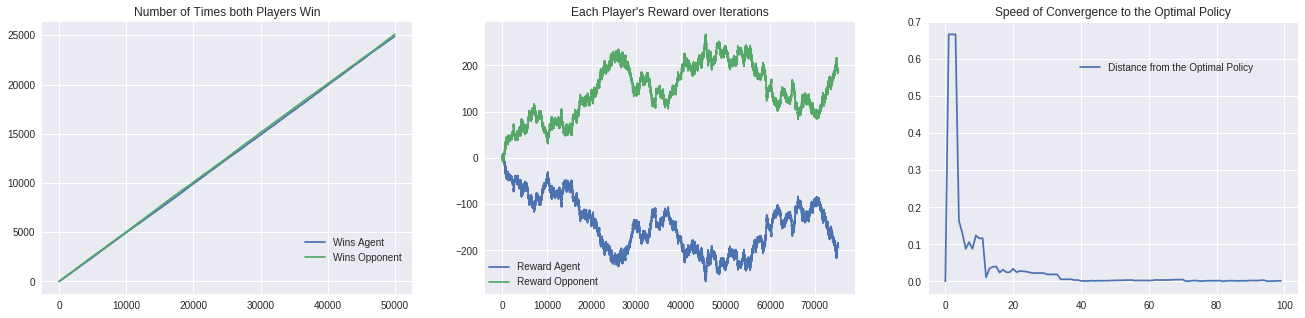


A - action 0: 0.332841
A - action 1: 0.331817
A - action 2: 0.335341

B - action 0: 0.334956
B - action 1: 0.331658
B - action 2: 0.333387

Wins A : 24904
Wins B : 25096
Draws  : 0

Reward A : -192
Reward B : 192


In [0]:
nx = 3
ny = 1

dxs = 7.5
dys = 5.0

fig, axes = plt.subplots(1, 3, figsize=(dxs*nx, dys*ny))
axes = axes.flatten()
for i_a in range(3):
  ax = axes[i_a]
  if i_a == 0:
    ax.plot((records == 1).cumsum())
    ax.plot((records == -1).cumsum())
    ax.legend(('Wins Agent', 'Wins Opponent'), loc=(0.7, 0.1))
    ax.set_title("Number of Times both Players Win")
  elif i_a == 1:
    ax.plot(np.array(R).cumsum())
    ax.plot(-np.array(R).cumsum())
    ax.legend(('Reward Agent', 'Reward Opponent'), loc=(0, 0.01))
    ax.set_title("Each Player's Reward over Iterations")
  elif i_a == 2:
    ax.plot(P_Diff[:100])
    ax.legend(('Distance from the Optimal Policy',), loc=(0.4, 0.8))
    ax.set_title("Speed of Convergence to the Optimal Policy")
plt.show()
fig.tight_layout()
plt.show()

print("\n==============")
print("A - action 0: %f" % (1. * sum(np.array(History_A) == 0) / len(History_A)))
print("A - action 1: %f" % (1. * sum(np.array(History_A) == 1) / len(History_A)))
print("A - action 2: %f" % (1. * sum(np.array(History_A) == 2) / len(History_A)))

print("\n==============")
print("B - action 0: %f" % (1. * sum(np.array(History_O) == 0) / len(History_O)))
print("B - action 1: %f" % (1. * sum(np.array(History_O) == 1) / len(History_O)))
print("B - action 2: %f" % (1. * sum(np.array(History_O) == 2) / len(History_O)))

print("\n==============")
print("Wins A : %d" % (records == 1).sum())
print("Wins B : %d" % (records == -1).sum())
print("Draws  : %d" % (records == 0).sum())

print("\n==============")
print("Reward A : %d" % sum(R))
print("Reward B : %d" % -sum(R))

In [0]:
iterations = 50000
records = np.zeros(iterations)
A = {0:"rock", 1:"paper", 2:"scissors"}
O = {0:"rock", 1:"paper", 2:"scissors"}
S = {0:"null"}
G = MatrixGame()
Opt = np.array([1./3, 1./3, 1./3])

decay = 10**(np.log10(0.01)/iterations)
drawProbability = 0.6

agent = Minimax_Q_Agent(S, A, O, gamma=1-drawProbability,  explor=0.01, decay=decay )
opponent = Rand_Agent(O)

History_A = []
History_O = []
R = []
P_Diff = []

for i in np.arange(iterations):
  if (i % (iterations / 10) == 0):
    print("%d%% finished." % (i * 100 / iterations))
  result = 0
  while result == 0:
    s = np.random.randint(0, len(S))
    a = agent.ChooseAction(s)
    o = opponent.ChooseAction(s)
    result = G.Play(a, o)
    
    History_A.extend([a])
    History_O.extend([o])
    P_Diff.extend([max(abs(agent.Pi[0] - Opt))])
    
    r = G.M[a, o]
    R.extend([r])
    
    agent.Learn(r, s, s, [a, o] )
    opponent.Learn(-r, s, s, [a, o] )
  records[i] = result

0% finished.
10% finished.
20% finished.
30% finished.
40% finished.
50% finished.
60% finished.
70% finished.
80% finished.
90% finished.


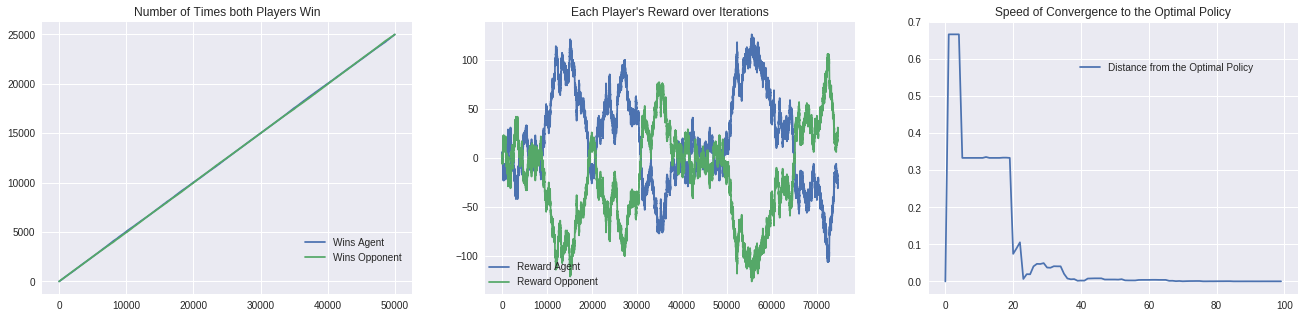


A - action 0: 0.336018
A - action 1: 0.332045
A - action 2: 0.331938

B - action 0: 0.332433
B - action 1: 0.336352
B - action 2: 0.331215

Wins A : 24987
Wins B : 25013
Draws  : 0

Reward A : -26
Reward B : 26


In [0]:
nx = 3
ny = 1

dxs = 7.5
dys = 5.0

fig, axes = plt.subplots(1, 3, figsize=(dxs*nx, dys*ny))
axes = axes.flatten()
for i_a in range(3):
  ax = axes[i_a]
  if i_a == 0:
    ax.plot((records == 1).cumsum())
    ax.plot((records == -1).cumsum())
    ax.legend(('Wins Agent', 'Wins Opponent'), loc=(0.7, 0.1))
    ax.set_title("Number of Times both Players Win")
  elif i_a == 1:
    ax.plot(np.array(R).cumsum())
    ax.plot(-np.array(R).cumsum())
    ax.legend(('Reward Agent', 'Reward Opponent'), loc=(0, 0.01))
    ax.set_title("Each Player's Reward over Iterations")
  elif i_a == 2:
    ax.plot(P_Diff[:100])
    ax.legend(('Distance from the Optimal Policy',), loc=(0.4, 0.8))
    ax.set_title("Speed of Convergence to the Optimal Policy")
plt.show()
fig.tight_layout()
plt.show()

print("\n==============")
print("A - action 0: %f" % (1. * sum(np.array(History_A) == 0) / len(History_A)))
print("A - action 1: %f" % (1. * sum(np.array(History_A) == 1) / len(History_A)))
print("A - action 2: %f" % (1. * sum(np.array(History_A) == 2) / len(History_A)))

print("\n==============")
print("B - action 0: %f" % (1. * sum(np.array(History_O) == 0) / len(History_O)))
print("B - action 1: %f" % (1. * sum(np.array(History_O) == 1) / len(History_O)))
print("B - action 2: %f" % (1. * sum(np.array(History_O) == 2) / len(History_O)))

print("\n==============")
print("Wins A : %d" % (records == 1).sum())
print("Wins B : %d" % (records == -1).sum())
print("Draws  : %d" % (records == 0).sum())

print("\n==============")
print("Reward A : %d" % sum(R))
print("Reward B : %d" % -sum(R))

In [0]:
iterations = 50000
records = np.zeros(iterations)
A = {0:"rock", 1:"paper", 2:"scissors"}
O = {0:"rock", 1:"paper", 2:"scissors"}
S = {0:"null"}
G = MatrixGame()
Opt = np.array([1./3, 1./3, 1./3])

decay = 0.5
drawProbability = 0.01

agent = Minimax_Q_Agent(S, A, O, gamma=1-drawProbability,  explor=0.01, decay=decay )
opponent = Rand_Agent(O)

History_A = []
History_O = []
R = []
P_Diff = []

for i in np.arange(iterations):
  if (i % (iterations / 10) == 0):
    print("%d%% finished." % (i * 100 / iterations))
  result = 0
  while result == 0:
    s = np.random.randint(0, len(S))
    a = agent.ChooseAction(s)
    o = opponent.ChooseAction(s)
    result = G.Play(a, o)
    
    History_A.extend([a])
    History_O.extend([o])
    P_Diff.extend([max(abs(agent.Pi[0] - Opt))])
    
    r = G.M[a, o]
    R.extend([r])
    
    agent.Learn(r, s, s, [a, o] )
    opponent.Learn(-r, s, s, [a, o] )
  records[i] = result

0% finished.
10% finished.
20% finished.
30% finished.
40% finished.
50% finished.
60% finished.
70% finished.
80% finished.
90% finished.


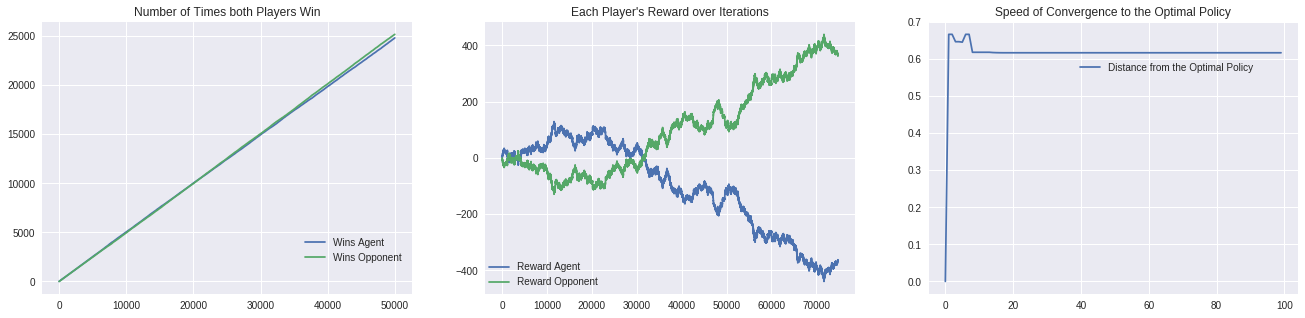


A - action 0: 0.053144
A - action 1: 0.003502
A - action 2: 0.943354

B - action 0: 0.331827
B - action 1: 0.336506
B - action 2: 0.331667

Wins A : 24819
Wins B : 25181
Draws  : 0

Reward A : -362
Reward B : 362


In [0]:
nx = 3
ny = 1

dxs = 7.5
dys = 5.0

fig, axes = plt.subplots(1, 3, figsize=(dxs*nx, dys*ny))
axes = axes.flatten()
for i_a in range(3):
  ax = axes[i_a]
  if i_a == 0:
    ax.plot((records == 1).cumsum())
    ax.plot((records == -1).cumsum())
    ax.legend(('Wins Agent', 'Wins Opponent'), loc=(0.7, 0.1))
    ax.set_title("Number of Times both Players Win")
  elif i_a == 1:
    ax.plot(np.array(R).cumsum())
    ax.plot(-np.array(R).cumsum())
    ax.legend(('Reward Agent', 'Reward Opponent'), loc=(0, 0.01))
    ax.set_title("Each Player's Reward over Iterations")
  elif i_a == 2:
    ax.plot(P_Diff[:100])
    ax.legend(('Distance from the Optimal Policy',), loc=(0.4, 0.8))
    ax.set_title("Speed of Convergence to the Optimal Policy")
plt.show()
fig.tight_layout()
plt.show()

print("\n==============")
print("A - action 0: %f" % (1. * sum(np.array(History_A) == 0) / len(History_A)))
print("A - action 1: %f" % (1. * sum(np.array(History_A) == 1) / len(History_A)))
print("A - action 2: %f" % (1. * sum(np.array(History_A) == 2) / len(History_A)))

print("\n==============")
print("B - action 0: %f" % (1. * sum(np.array(History_O) == 0) / len(History_O)))
print("B - action 1: %f" % (1. * sum(np.array(History_O) == 1) / len(History_O)))
print("B - action 2: %f" % (1. * sum(np.array(History_O) == 2) / len(History_O)))

print("\n==============")
print("Wins A : %d" % (records == 1).sum())
print("Wins B : %d" % (records == -1).sum())
print("Draws  : %d" % (records == 0).sum())

print("\n==============")
print("Reward A : %d" % sum(R))
print("Reward B : %d" % -sum(R))

# Soccer Game

__Game factors__:

*   A state set $\underline{\textbf{S}}$ with $4\times5$ elements, which represent the specific coordinates for all $4\times5$ grids
*   Two Players, A and B, which occupy distinct squares of the grid
*   Each player has $5$ actions on each turn: N, S, E, W, and stand

__Assumptions__:

*   The selected actions of both players are executed in random order
*   Possession of the ball goes to one or the other player at random

__Rule for the Game__:

*   When a player executes an action that would take it to the square occupied by the other player, possession of the ball goes to the stationary player and the move does not take place

__Goal__: The player with the ball(the circle) steps into the appropriate place: left for A, right for B. Then, player scores a point and the board is reset to the initial state.

In [0]:
class Soccer:
  def __init__(self, X_Lims = 5, Y_Lims = 4, Des_Y = [1, 2], Init_A = [3, 2], Init_O = [1,1], P_draw=0.1):
    # The Size of Play Ground
    self.X_Lims = X_Lims
    self.Y_Lims = Y_Lims
    
    # Y Coordinates of the Destination
    self.Des_Y = Des_Y
    
    self.Init_A = Init_A
    self.Init_O = Init_O
    
    self.Draw = P_draw
    
    self.init_params()
  
  # Reset this Game
  def init_params(self):
    # Action Set A and Player Set I
    self.A = {0:"Left", 1:"Up", 2:"Right", 3:"Down", 4:"No"}
    self.I = {0:"Agent", 1:"Opponent"}
    
    # The initial Locations of both Players
    self.Init_Locs = np.array([self.Init_A, self.Init_O])
    
    # Current Locations of both Players
    self.Locations = self.Init_Locs.copy()
    
    # The Ownership of the Ball: A=0, B=1
    self.Ownership = np.random.randint(0, 2)
    
    # Offset for each Action
    self.Offsets = {
                      0: [-1, 0],
                      1: [0, 1],
                      2: [1, 0],
                      3: [0, -1],
                      4: [0, 0],
                   }   
  
  # Validate the New Location
  def IsValid(self, new_loc):
    return (0 <= new_loc[0] < self.X_Lims and 0 <= new_loc[1] < self.Y_Lims)

  # Check whether the new Location is in the Destination
  def IsReach(self, new_loc):
    if (self.Des_Y[0] <= new_loc[1] <= self.Des_Y[1] ):
      if (new_loc[0] == -1 and self.Ownership == 0):
        return 1  # A won
      elif (new_loc[0] == self.X_Lims and self.Ownership == 1):
        return -1 # B won
    return 0
      
  # Execute player's action
  def Move(self, player, action):
    opponent = 1 - player

    # Update the location of the player
    New_Loc = self.Locations[player] + self.Offsets[action]
    
    # If new Location is occupied by opponent, ownership is changed
    if (New_Loc == self.Locations[opponent]).all():
      self.Ownership = opponent
    # If new Location is the destination
    elif self.Ownership == player and self.IsReach(New_Loc) != 0:
      return self.IsReach(New_Loc)
    # Coordinate is valid
    elif self.IsValid(New_Loc):
      self.Locations[player] = New_Loc
    
    return 0
  
  def Play(self, actions):
    # Players draw with some certainty
    if np.random.rand() < self.Draw:
      #print("Draw!")
      return -2
  
    # Moves are executed in random order
    first = np.random.randint(0,2)
    second = 1 - first

    # Is there someone reaching the desitination
    score = 0

    # The agent's turn
    score = self.Move(first, actions[first])
    if (score != 0):
      return score

    #The opponent's turn
    return self.Move(second, action[second])
  
  
  def Plot(self, positions=None, ballOwner=None):
    Locs = self.Locations if positions is None else np.array(positions)
    Owner = self.Ownership if ballOwner is None else ballOwner

    State = ''
    for y in range(self.Y_Lims)[::-1]:
      for x in range(self.X_Lims):
        if ([x, y] == Locs[0]).all():
          State += 'A' if Owner is 0 else 'a'
        elif ([x, y] == Locs[1]).all():
          State += 'B' if Owner is 1 else 'b'
        else:
          State += '-'
      State += '\n'

    print(State)

In [0]:
G = Soccer()
G.Plot()
#actions = [[0, 1], [0, 4], [1, 3], [1, 2], [1, 2], [4, 2], [4, 2]]
actions = [[0, 4], [0, 4], [0, 4], [0, 4], [0, 4]]
i = 1
for action in actions:
    print("iteration:{} - A:{}, B:{}".format(i, G.A[action[0]],G.A[action[1]]))
    print("The Result of Move: %d"% G.Play(action))
    G.Plot()
    i += 1
    print("\n=======================>")

-----
---A-
-b---
-----

iteration:1 - A:Left, B:No
The Result of Move: 0
-----
--A--
-b---
-----


=======================>
iteration:2 - A:Left, B:No
The Result of Move: 0
-----
-A---
-b---
-----


=======================>
iteration:3 - A:Left, B:No
The Result of Move: 0
-----
A----
-b---
-----


=======================>
iteration:4 - A:Left, B:No
The Result of Move: 1
-----
A----
-b---
-----


=======================>
iteration:5 - A:Left, B:No
The Result of Move: 1
-----
A----
-b---
-----


=======================>


In [0]:
def boardToState(G):
  x_A, y_A = G.Locations[0]
  x_B, y_B = G.Locations[1]
  s_A = y_A * G.X_Lims + x_A
  s_B = y_B * G.X_Lims + x_B
  s_B -= 1 if s_B > s_A else 0
  
  return ((s_A * (G.X_Lims * G.Y_Lims - 1) + s_B)\
          + (G.X_Lims * G.Y_Lims) * (G.X_Lims * G.Y_Lims - 1) * G.Ownership)

def stateToBoard(G, state):
  Ownership = state / ((G.X_Lims * G.Y_Lims) * (G.X_Lims * G.Y_Lims - 1))
  state = state % ((G.X_Lims * G.Y_Lims) * (G.X_Lims * G.Y_Lims - 1))

  s_A = state / (G.X_Lims * G.Y_Lims - 1)
  s_B = state % (G.X_Lims * G.Y_Lims - 1)
  s_B += 1 if s_B >= s_A else 0

  x_A = s_A % G.X_Lims
  y_A = s_A / G.X_Lims
  x_B = s_B % G.X_Lims
  y_B = s_B / G.X_Lims
  
  return [[[x_A, y_A], [x_B, y_B]], Ownership]

def plotResult(wins):
  sumWins = (wins == [[1], [-1], [-2]]).sum(1)
  lenWins = sumWins[0] + sumWins[1]
  print("Completed %d games" % (sumWins.sum()))
  print("Wins A : %d (%0.1f%%)" % (sumWins[0], (100. * sumWins[0] / lenWins)))
  print("Wins B : %d (%0.1f%%)" % (sumWins[1], (100. * sumWins[1] / lenWins)))
  print("Draws  : %d (%0.1f%%)" % (sumWins[2], (100. * sumWins[2] / sumWins.sum())))

  plt.plot((wins == 1).cumsum())
  plt.plot((wins == -1).cumsum())
  plt.legend(('WinsA', 'WinsB'), loc=(0.6, 0.8))
  plt.show()

In [0]:
iterations = 100000
Y_Lims = 4
X_Lims = 5
S = [ i for i in np.arange((X_Lims * Y_Lims) * (X_Lims * Y_Lims - 1) * 2)] 
A = {0:"Left", 1:"Up", 2:"Right", 3:"Down", 4:"No"}
O = {0:"Left", 1:"Up", 2:"Right", 3:"Down", 4:"No"}

decay = 10**(np.log10(0.01)/iterations)
draw = 0.01

MR = Minimax_Q_Agent(S, A, O, gamma=1-draw, explor=0.2, decay=decay )
R1 = Rand_Agent(A)

G = Soccer(P_draw=draw)

win_MR = np.zeros(iterations)
r = 0
for i in np.arange(iterations):
    if (i % (iterations / 10) == 0):
        print("%d%%" % (i * 100 / iterations))
    
    s = boardToState(G)
    a = MR.ChooseAction(s)
    o = R1.ChooseAction(s)
    r = G.Play([a, o])
    reward = 0 if r == -2 or r == 0 else r
    new_s = boardToState(G)
        
    MR.Learn(reward, s, new_s, [a, o] )
    R1.Learn(-reward, s, new_s, [a, o] )
    
    if r != 0:
      win_MR[i] = r
      G.init_params()
      r = 0

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


Completed 5441 games
Wins A : 3101 (69.4%)
Wins B : 1368 (30.6%)
Draws  : 972 (17.9%)


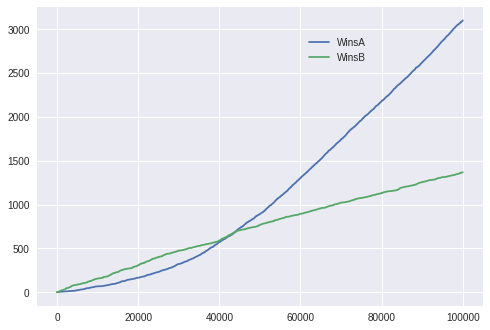

In [0]:
plotResult(win_MR) 

In [0]:
iterations = 100000
Y_Lims = 4
X_Lims = 5
S = [ i for i in np.arange((X_Lims * Y_Lims) * (X_Lims * Y_Lims - 1) * 2)] 
A = {0:"Left", 1:"Up", 2:"Right", 3:"Down", 4:"No"}
O = {0:"Left", 1:"Up", 2:"Right", 3:"Down", 4:"No"}

decay = 10**(np.log10(0.01)/iterations)
draw = 0.01

MM = Minimax_Q_Agent(S, A, O, gamma=1-draw, explor=0.2, decay=decay )
M1 = Minimax_Q_Agent(S, A, O, gamma=1-draw,  explor=0.2, decay=decay )

G = Soccer(P_draw=draw)

win_MM = np.zeros(iterations)
r = 0

for i in np.arange(iterations):
    if (i % (iterations / 10) == 0):
        print("%d%%" % (i * 100 / iterations))
    
    s = boardToState(G)
    a = MM.ChooseAction(s)
    o = M1.ChooseAction(s)
    r = G.Play([a, o])
    reward = 0 if r == -2 or r == 0 else r
    new_s = boardToState(G)
        
    MM.Learn(reward, s, new_s, [a, o] )
    M1.Learn(-reward, s, new_s, [a, o] )
    
    if r != 0:
      win_MM[i] = r
      G.init_params()
      r = 0

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


Completed 5497 games
Wins A : 3192 (70.8%)
Wins B : 1318 (29.2%)
Draws  : 987 (18.0%)


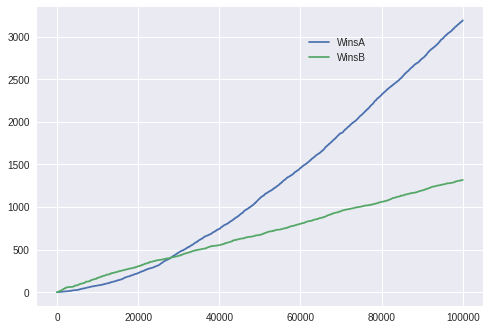

In [0]:
 plotResult(win_MM)

In [0]:
iterations = 100000
Y_Lims = 4
X_Lims = 5
S = [ i for i in np.arange((X_Lims * Y_Lims) * (X_Lims * Y_Lims - 1) * 2)] 
A = {0:"Left", 1:"Up", 2:"Right", 3:"Down", 4:"No"}
O = {0:"Left", 1:"Up", 2:"Right", 3:"Down", 4:"No"}

decay = 10**(np.log10(0.01)/iterations)
draw = 0.01

QR = Q_Agent(S, A, gamma=1-draw, explor=0.2, decay=decay )
R2 = Rand_Agent(A)

G = Soccer(P_draw=draw)

win_QR = np.zeros(iterations)
r = 0
for i in np.arange(iterations):
    if (i % (iterations / 10) == 0):
        print("%d%%" % (i * 100 / iterations))
    
    s = boardToState(G)
    a = QR.ChooseAction(s)
    o = R2.ChooseAction(s)
    r = G.Play([a, o])
    reward = 0 if r == -2 or r == 0 else r
    new_s = boardToState(G)
        
    QR.Learn(reward, s, new_s, [a, o] )
    R2.Learn(-reward, s, new_s, [a, o] )
    
    if r != 0:
      win_QR[i] = r
      G.init_params()
      r = 0

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


Completed 4441 games
Wins A : 2812 (83.6%)
Wins B : 552 (16.4%)
Draws  : 1077 (24.3%)


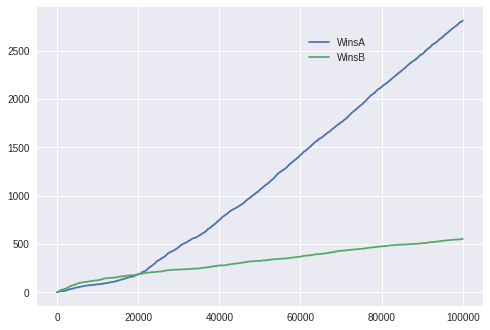

In [0]:
 plotResult(win_QR)

In [0]:
iterations = 100000
Y_Lims = 4
X_Lims = 5
S = [ i for i in np.arange((X_Lims * Y_Lims) * (X_Lims * Y_Lims - 1) * 2)] 
A = {0:"Left", 1:"Up", 2:"Right", 3:"Down", 4:"No"}
O = {0:"Left", 1:"Up", 2:"Right", 3:"Down", 4:"No"}

decay = 10**(np.log10(0.01)/iterations)
draw = 0.01

QQ = Q_Agent(S, A, gamma=1-draw, explor=0.2, decay=decay )
Q1 = Q_Agent(S, A, gamma=1-draw, explor=0.2, decay=decay )

G = Soccer(P_draw=draw)

win_QQ = np.zeros(iterations)
r = 0
for i in np.arange(iterations):
    if (i % (iterations / 10) == 0):
        print("%d%%" % (i * 100 / iterations))

    s = boardToState(G)
    a = QQ.ChooseAction(s)
    o = Q1.ChooseAction(s)
    r = G.Play([a, o])
    reward = 0 if r == -2 or r == 0 else r
    new_s = boardToState(G)
        
    QQ.Learn(reward, s, new_s, [a, o] )
    Q1.Learn(-reward, s, new_s, [a, o] )
    
    if r != 0:
      win_QQ[i] = r
      G.init_params()
      r = 0

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


Completed 12746 games
Wins A : 2285 (82.6%)
Wins B : 481 (17.4%)
Draws  : 9980 (78.3%)


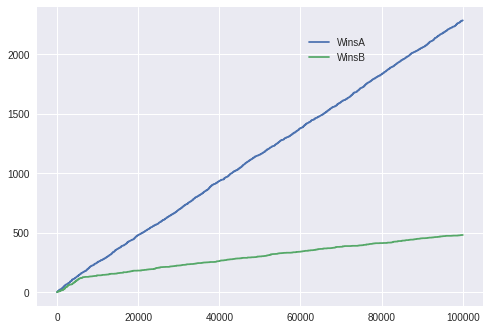

In [0]:
 plotResult(wins)

In [0]:
iterations = 100000
Y_Lims = 4
X_Lims = 5
S = [ i for i in np.arange((X_Lims * Y_Lims) * (X_Lims * Y_Lims - 1) * 2)] 
A = {0:"Left", 1:"Up", 2:"Right", 3:"Down", 4:"No"}
O = {0:"Left", 1:"Up", 2:"Right", 3:"Down", 4:"No"}

decay = 10**(np.log10(0.01)/iterations)
draw = 0.1

Rand = Rand_Agent(A)
MR.learning = False

G = Soccer(P_draw=draw)

wins_MR = np.zeros(iterations)
r = 0
for i in np.arange(iterations):
    if (i % (iterations / 10) == 0):
        print("%d%%" % (i * 100 / iterations))
    
    s = boardToState(G)
    a = MR.ChooseAction(s)
    o = Rand.ChooseAction(s)
    r = G.Play([a, o])
    reward = 0 if r == -2 or r == 0 else r
    new_s = boardToState(G)
        
    MR.Learn(reward, s, new_s, [a, o] )
    Rand.Learn(-reward, s, new_s, [a, o] )
    
    if r != 0:
      wins_MR[i] = r
      G.init_params()
      r = 0

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


Completed 14271 games
Wins A : 3799 (87.9%)
Wins B : 524 (12.1%)
Draws  : 9948 (69.7%)


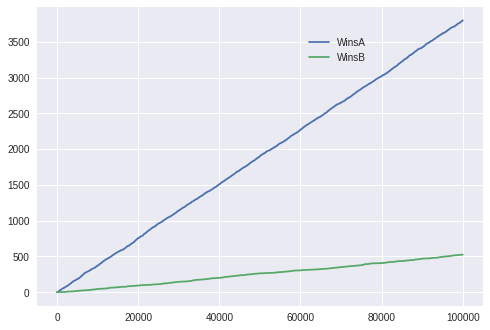

In [0]:
 plotResult(wins_MR)

In [0]:
iterations = 100000
Y_Lims = 4
X_Lims = 5
S = [ i for i in np.arange((X_Lims * Y_Lims) * (X_Lims * Y_Lims - 1) * 2)] 
A = {0:"Left", 1:"Up", 2:"Right", 3:"Down", 4:"No"}
O = {0:"Left", 1:"Up", 2:"Right", 3:"Down", 4:"No"}

decay = 10**(np.log10(0.01)/iterations)
draw = 0.1

MM.learning = False

G = Soccer(P_draw=draw)

wins_MM = np.zeros(iterations)
r = 0
for i in np.arange(iterations):
    if (i % (iterations / 10) == 0):
        print("%d%%" % (i * 100 / iterations))
    
    s = boardToState(G)
    a = MM.ChooseAction(s)
    o = Rand.ChooseAction(s)
    r = G.Play([a, o])
    reward = 0 if r == -2 or r == 0 else r
    new_s = boardToState(G)
        
    MM.Learn(reward, s, new_s, [a, o] )
    Rand.Learn(-reward, s, new_s, [a, o] )
    
    if r != 0:
      wins_MM[i] = r
      G.init_params()
      r = 0

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


Completed 13660 games
Wins A : 2834 (76.2%)
Wins B : 884 (23.8%)
Draws  : 9942 (72.8%)


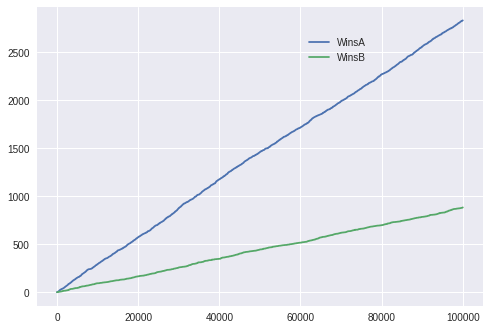

In [0]:
 plotResult(wins_MM)

In [0]:
iterations = 100000
Y_Lims = 4
X_Lims = 5
S = [ i for i in np.arange((X_Lims * Y_Lims) * (X_Lims * Y_Lims - 1) * 2)] 
A = {0:"Left", 1:"Up", 2:"Right", 3:"Down", 4:"No"}
O = {0:"Left", 1:"Up", 2:"Right", 3:"Down", 4:"No"}

decay = 10**(np.log10(0.01)/iterations)
draw = 0.1

QR.learning = False

G = Soccer(P_draw=draw)

wins_QR = np.zeros(iterations)
r = 0
for i in np.arange(iterations):
    if (i % (iterations / 10) == 0):
        print("%d%%" % (i * 100 / iterations))
    
    s = boardToState(G)
    a = QR.ChooseAction(s)
    o = Rand.ChooseAction(s)
    r = G.Play([a, o])
    reward = 0 if r == -2 or r == 0 else r
    new_s = boardToState(G)
        
    QR.Learn(reward, s, new_s, [a, o] )
    Rand.Learn(-reward, s, new_s, [a, o] )
    
    if r != 0:
      wins_QR[i] = r
      G.init_params()
      r = 0

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


Completed 12474 games
Wins A : 2373 (95.7%)
Wins B : 107 (4.3%)
Draws  : 9994 (80.1%)


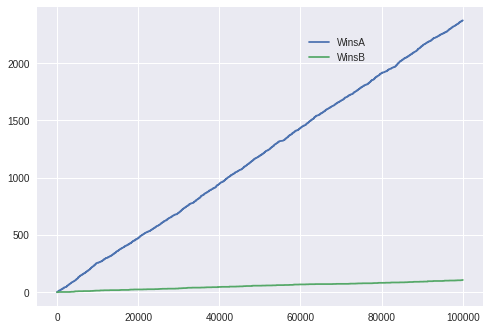

In [0]:
 plotResult(wins_QR)

In [0]:
iterations = 100000
Y_Lims = 4
X_Lims = 5
S = [ i for i in np.arange((X_Lims * Y_Lims) * (X_Lims * Y_Lims - 1) * 2)] 
A = {0:"Left", 1:"Up", 2:"Right", 3:"Down", 4:"No"}
O = {0:"Left", 1:"Up", 2:"Right", 3:"Down", 4:"No"}

decay = 10**(np.log10(0.01)/iterations)
draw = 0.1

QQ.learning = False

G = Soccer(P_draw=draw)

wins_QQ = np.zeros(iterations)
r = 0
for i in np.arange(iterations):
    if (i % (iterations / 10) == 0):
        print("%d%%" % (i * 100 / iterations))
    
    s = boardToState(G)
    a = QQ.ChooseAction(s)
    o = Rand.ChooseAction(s)
    r = G.Play([a, o])
    reward = 0 if r == -2 or r == 0 else r
    new_s = boardToState(G)
        
    QQ.Learn(reward, s, new_s, [a, o] )
    Rand.Learn(-reward, s, new_s, [a, o] )
    
    if r != 0:
      wins_QQ[i] = r
      G.init_params()
      r = 0

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


Completed 11243 games
Wins A : 997 (75.4%)
Wins B : 325 (24.6%)
Draws  : 9921 (88.2%)


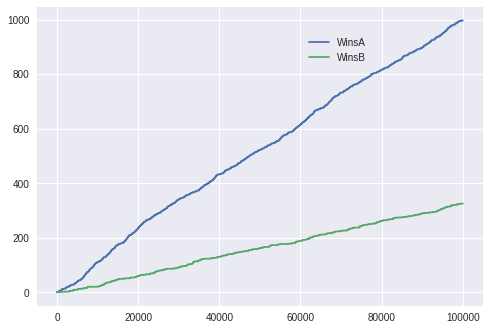

In [0]:
 plotResult(wins_QQ)

In [0]:
class Minimax_Q_Agent:
  def __init__(self, S, A, O, gamma, explor, decay):
    self.S = S
    self.A = A
    self.O = O
    self.Q = np.ones((len(S), len(A), len(O)), dtype=np.float32)
    self.V = np.ones( len(S), dtype=np.float32)
    self.Pi = np.ones((len(S), len(A)), dtype=np.float32) / len(A)
    self.alpha = 1.0
    self.gamma = gamma
    self.explor = explor
    self.decay = decay
    self.learning = True
    
  def ChooseAction(self, s):
    if self.learning and np.random.rand() < self.explor:
      return np.random.randint(len(self.A))
    else:
      p = np.random.rand()
      a = 0
      a += np.sum(p > np.cumsum(self.Pi[s]))
      return a
    
  def Learn(self, rew, s, s_, actions):
    if not self.learning:
      return
    
    a, o = actions
    self.Q[s, a, o] = (1-self.alpha) * self.Q[s, a, o] \
                          + self.alpha * (rew + self.gamma * self.V[s_])
    self.V[s] = self.UpdatePi(s)
    self.alpha *= self.decay
  
  def UpdatePi(self, s, stop=False):
    Coeffs_Obj = np.zeros(len(self.A) + 1)
    Coeffs_Obj[0] = -1
    
    Coeffs_Inq = np.ones((len(self.O), len(self.A) + 1))
    Coeffs_Inq[:,1:] = -self.Q[s,:,:].T
    UB_Inq = np.zeros(len(self.O))
    
    Coeffs_Eq = np.ones((1, len(self.A) + 1))
    Coeffs_Eq[0,0] = 0
    UB_Eq = [1]
    
    Bounds = ((None, None),)
    for i in np.arange(len(self.A)):
      Bounds += ((0, 1),)
    
    res = linprog(Coeffs_Obj, A_ub=Coeffs_Inq, b_ub=UB_Inq\
                    , A_eq=Coeffs_Eq, b_eq=UB_Eq, bounds=Bounds)
    
    if res.success:
      self.Pi[s] = res.x[1:]
    elif not stop:
      return self.UpdatePi(s, stop=True)
    else:
      #print("Alert : %s" % res.message)
      return self.V[s]
    
    return res.x[0]
  
  def PiPerState(self, s):
        for a in range(len(self.A)):
            print("Action ID: {}, Name: {} : P={}".format(a, self.A[a], self.Pi[s, a]))

In [0]:
agent = Minimax_Q_Agent({0:"null"}, {0:"head", 1:"tail"}, {0:"head",1:"tail"}, 1e-4, 0.2, 0.9)
agent.Q[0] = [[0, 1], [1, 0.5]]
V = agent.UpdatePi(0)
print(agent.Pi)
agent.PiPerState(0)

In [0]:
class Q_Agent():
  def __init__(self, S, A, gamma, explor, decay):
    self.S = S
    self.A = A
    self.Q = np.ones((len(S), len(A)))
    self.V = np.ones(len(S))
    self.Pi = np.ones((len(S), len(A))) / len(A)
    self.alpha = 1.0
    self.gamma = gamma
    self.explor = explor
    self.decay = decay
    self.learning = True
    
  def ChooseAction(self, s):
    if self.learning and np.random.rand() < self.explor:
      return np.random.randint(len(self.A))
    else:
      return np.argmax(self.Q[s])
  
  def Learn(self, rew, s, s_, actions):
    if not self.learning:
      return
    
    a, o = actions
    self.Q[s, a] = (1 - self.alpha) * self.Q[s, a] + self.alpha * (rew + self.gamma * self.V[s_])
    self.Pi[s] = np.zeros(len(self.A))
    self.Pi[s, np.argmax(self.Q[s])] = 1
    self.V[s] = self.Q[s, np.argmax(self.Q[s])]
    self.alpha *= self.decay
    
  def PiPerState(self, s):
    for a in np.arange(len(self.A)):
      print("Action ID: {}, Name: {} : P={}".format(a, self.A[a], self.Pi[s, a]))

In [0]:
agent = Q_Agent({0:"null"}, {0:"head", 1:"tail"}, 1e-4, 0.2, 0.9)
agent.Q[0] = [1.0, 0.5]
agent.Learn(1, 0, 0, [0, 0])
print(agent.Q)
agent.PiPerState(0)

In [0]:
class Rand_Agent():
  def __init__(self, A):
    self.A = A
    
  def ChooseAction(self, s):
    return np.random.randint(len(self.A))
  
  def Learn(self, rew, s, s_, actions):
    pass

In [0]:
agent = Rand_Agent({0:"head", 1:"tail"})
print(agent.A[agent.ChooseAction(0)])